In [1]:
import pandas as pd
import numpy as np
import random
import math
import preprocessor as p
from nltk.corpus import stopwords
import nltk
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
import string
import spacy
import es_core_news_sm
import re
from pprint import pprint

In [2]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [3]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [5]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Import Data

In [6]:
from import_data import read_data

In [7]:
data = read_data('../data', 2016, 2016, 1)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/Users/lthomas/Dropbox/galvanize/Capstone/notebooks/import_data.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data1_cleaned["tweet_time"] = pd.to_datetime(data1_cleaned["tweet_time"])
/Users/lthomas/Dropbox/galvanize/Capstone/notebooks/import_data.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data1_cleane

## Filter Out RTs

In [8]:
unique_data = data[data.is_retweet == False]

## Group by UserID, Month, Year

In [9]:
def create_user_docs(tweets_vec):
    return " ".join([tweet for tweet in tweets_vec ])

In [10]:
docs = unique_data.groupby(['userid', 'year', 'month'])

In [11]:
df_tweets = docs['tweet_text'].apply(create_user_docs)

In [12]:
df_tweets.head()

userid                                        year  month
+EM0FN2MVJv+wZEFpmmDTPfSvheVWzeVSNXSwx9ulOE=  2016  3                  #BuenViernes Desarrolla tu ser interno.
+dQ+QlvsYdF8Lald5LNFZRmGAJVayY9jpoeDm4mvMko=  2016  1        Sueño ven a mi. Todo lo que hagas importa. El ...
                                                    2        El peor error que alguien puede cometer es cre...
                                                    3        Una cadena es tan fuerte como su eslabón más f...
                                                    4        Esteros y morichales. Es ahora o nunca, si qui...
Name: tweet_text, dtype: object

### Filter out users with tweets less than 10 words

In [13]:
tweet_len = pd.Series(df_tweets).apply(lambda x:  len(x.split()))

In [15]:
pd.Series(tweet_len).describe()

count      3764.000000
mean       8867.054463
std       37423.445337
min           1.000000
25%          57.000000
50%         396.000000
75%        3553.500000
max      859347.000000
Name: tweet_text, dtype: float64

In [16]:
df_tweets = df_tweets[ tweet_len > 10 ]

In [17]:
data_list = df_tweets.values.tolist()

## Text Preprocessing Pipeline

### Define functions for processing

In [18]:
def remove_url_emojis(tweets):
    '''
    input: tweets is a list of strings (untokenized)
    output: list of strings (untokenized)
    '''
    p.set_options(p.OPT.EMOJI, p.OPT.URL, p.OPT.RESERVED, p.OPT.NUMBER)
    
    return [ p.clean(tweet) for tweet in tweets ]

In [19]:
def tweet_to_tokens(tweets):
    return [ [token.lower() for token in tweet.split()
                 if (len(token) >= 3) and (len(token) <= 15)] for tweet in tweets]

In [20]:
def remove_symbols(tweets):
    '''
    input: tweets is a list of list of tokens
    output: list of list of tokens
    '''
    symbol_set = set('!"$%&\'()*,-./:;<>?[\\]^_`{|}~¿… °¡')
    
    return [[''.join(char for char in token if char not in symbol_set) 
              for token in tweet] 
                for tweet in tweets]

In [21]:
def remove_accents(tweets):
    def accent_check(char):
        accents = set('áéíóñ')
        if char not in accents:
            return char
        elif char == 'á':
            return 'a'
        elif char == 'é':
            return 'e'
        elif char == 'í':
            return 'i'
        elif char == 'ó':
            return 'o'
        elif char == 'ú':
            return 'u'
        elif char == 'ñ':
            return 'n'
    
    return [[ ''.join(accent_check(char) for char in token) 
                for token in tweet]
                    for tweet in tweets]

In [22]:
def remove_stopwords(tweets):
    '''
    input: tweets is a list of list of tokens
    output: list of list of cleaner tokens
    '''

    # NLTK Stop words
    stop_words_es = stopwords.words('spanish')
    stop_words_en = stopwords.words('english')
    stop_words = stop_words_es + stop_words_en
    stop_words.extend(['lol', 'LOL', 'Lol', 'LoL', 'jaja', 'jajaj'])

    return [[token for token in tweet 
                     if token not in stop_words] 
                        for tweet in tweets]

In [23]:
def make_bigrams(tweets):
    return [bigram_mod[tweet] for tweet in tweets]

In [24]:
def make_trigrams(tweets):
    return [trigram_mod[bigram_mod[tweet]] for tweet in tweets]

In [25]:
def lemmatization(tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Lemmatize and rejoin
    
    #nlp = es_core_news_sm.load()
    tweets_out = []
    for tweet in tweets:
        doc = nlp(" ".join(tweet)) 
        tweets_out.append([token.lemma_ for token in doc 
                           if token.pos_ in allowed_postags])
    return tweets_out

### Remove URLS and Emojis

In [26]:
data_no_entities = remove_url_emojis(data_list)

### Tokenize tweets

In [27]:
data_tokens = tweet_to_tokens(data_no_entities)

### Remove symbols

In [28]:
data_nosymbols = remove_symbols(data_tokens)

### Remove accents

In [29]:
data_noaccents = remove_accents(data_nosymbols)

### Final Word List

In [31]:
data_words = data_noaccents

### Create Bigram/Trigram Models

In [32]:
# Create Bigram & Trigram Models

# Build the bigram and trigram models - higher threshold fewer phrases.
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Remove stopwords (english and spanish)

In [33]:
data_words_nostops = remove_stopwords(data_words)

### Form Bigrams

In [34]:
data_words_bigrams = make_bigrams(data_words_nostops)

### Perform lemmatization

In [35]:
nlp = spacy.load('es', disable=['parser', 'ner'], max_length = 30000000)
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

### Finally remove misc characters

In [36]:
def remove_misc(tweets):
    misc_chars = set(['#','🇻','🇪','jajajajaja','”','‘','’', \
                      'rt', 'jajaja', 'mas', 'asi', '’s', 'via'])
    
    return [[token for token in tweet 
                     if token not in misc_chars] 
                        for tweet in tweets]

In [37]:
data_lem_final = remove_misc(data_lemmatized)

## Create Dictionary and Corpus

In [38]:
# Create Dictionary
id2word = corpora.Dictionary(data_lem_final)

# Create Corpus
tweets = data_lem_final

# Term Document Frequency
corpus = [id2word.doc2bow(tweet) for tweet in tweets]

# View
#print(corpus[24])

## Build Preliminary Topic Model

In [39]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [40]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"venezuela" + 0.011*"venezolano" + 0.010*"foto" + 0.008*"madurar" + '
  '0.008*"ano" + 0.007*"presidente" + 0.007*"nacional" + 0.007*"nuevo" + '
  '0.007*"gobernar" + 0.005*"diputar"'),
 (1,
  '0.075*"tecnologia" + 0.031*"nuevo" + 0.029*"android" + 0.015*"videojuego" + '
  '0.014*"google" + 0.013*"ultimar" + 0.010*"ahora" + 0.009*"llegar" + '
  '0.007*"facebook" + 0.007*"apple"'),
 (2,
  '0.006*"llamar" + 0.005*"gobernar" + 0.005*"iran" + 0.005*"nuevo" + '
  '0.004*"ministro" + 0.004*"pedir" + 0.004*"zika" + 0.004*"militar" + '
  '0.004*"sirio" + 0.004*"seguridad"'),
 (3,
  '0.002*"kervin_pinerúa" + 0.000*"alta_denominacion" + 0.000*"recipes" + '
  '0.000*"bodegon" + 0.000*"cajeros_bancos" + 0.000*"firma_electronica" + '
  '0.000*"tramitar_antecedentes" + 0.000*"parque_acuatico" + '
  '0.000*"hermano_primo" + 0.000*"falsas_expectativas"'),
 (4,
  '0.313*"último" + 0.302*"latam" + 0.302*"hora" + 0.000*"muralla" + '
  '0.000*"noticiar" + 0.000*"news" + 0.000*"loultimo" + 0.

### Compute Perplexity and Coherence Scores

In [41]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lem_final, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.91648366044488

Coherence Score:  0.4431498478191667


In [42]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.297775  0.012081       1        1  25.352552
8      0.239801 -0.101870       2        1  17.159090
13     0.225778  0.033903       3        1  11.258342
0      0.255905 -0.074003       4        1  10.628120
1      0.200262  0.043242       5        1   5.663424
9      0.075759 -0.085181       6        1   5.289991
12     0.116820 -0.034262       7        1   4.641607
2      0.177967 -0.050495       8        1   3.929536
6      0.023017  0.390708       9        1   3.902828
5      0.148504 -0.026429      10        1   3.808370
14     0.187825 -0.028658      11        1   3.234461
18     0.129160 -0.084258      12        1   3.069932
4     -0.137640  0.285488      13        1   1.345271
17    -0.119394  0.058813      14        1   0.630341
19    -0.242880 -0.091246      15        1   0.068039
3     -0.315771 -0.049564      16        1   0.013396
11    -0.316820 -0.049042      17        1   0.004017
7     -0.315415 -0.049717      18        1   0.000502
16    -0.315327 -0.049756      19        1   0.000097
15    -0.315327 -0.049756      20        1   0.000095, topic_info=      Category           Freq                Term          Total  loglift  \
term                                                                        
6628   Default  638173.000000            noticiar  638173.000000  30.0000   
7681   Default  161788.000000               trump  161788.000000  29.0000   
18     Default   71545.000000               ahora   71545.000000  28.0000   
1331   Default  159515.000000               video  159515.000000  27.0000   
2192   Default   73165.000000              último   73165.000000  26.0000   
318    Default   67197.000000                hora   67197.000000  25.0000   
14158  Default   53921.000000               latam   53921.000000  24.0000   
8012   Default  101625.000000             android  101625.000000  23.0000   
634    Default   59763.000000          tecnologia   59763.000000  22.0000   
427    Default  102660.000000               mundo  102660.000000  21.0000   
445    Default   44768.000000               obama   44768.000000  20.0000   
3203   Default   50028.000000                vzla   50028.000000  19.0000   
18933  Default   29808.000000              chiste   29808.000000  18.0000   
2259   Default   48666.000000         interesante   48666.000000  17.0000   
2684   Default   59887.000000             madurar   59887.000000  16.0000   
503    Default   40067.000000              poblar   40067.000000  15.0000   
675    Default  101747.000000           venezuela  101747.000000  14.0000   
574    Default   79596.000000               rusia   79596.000000  13.0000   
18208  Default   21285.000000             hillary   21285.000000  12.0000   
2738   Default  110374.000000                eeuu  110374.000000  11.0000   
443    Default  101974.000000               nuevo  101974.000000  10.0000   
2629   Default   18942.000000              patrio   18942.000000   9.0000   
5360   Default   21473.000000              donald   21473.000000   8.0000   
2569   Default   39873.000000            nacional   39873.000000   7.0000   
2640   Default   11876.000000          revolucion   11876.000000   6.0000   
464    Default   32615.000000                pais   32615.000000   5.0000   
42     Default   70727.000000                 ano   70727.000000   4.0000   
453    Default   22376.000000                 ojo   22376.000000   3.0000   
7338   Default   49827.000000                ruso   49827.000000   2.0000   
180    Default   24529.000000               decir   24529.000000   1.0000   
...        ...            ...                 ...            ...      ...   
76913  Topic20       0.000063     anillos_saturno       1.928972   3.5422   
66271  Topic20       0.000063     claros_sintomas       1.928971   3.5422   
66293  Topic20       0.000063          coaliccion       1.928971   3.5422 

## Optimal Number of Topics

In [43]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Breadth Search

In [44]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lem_final, start=2, limit=150, step=25)

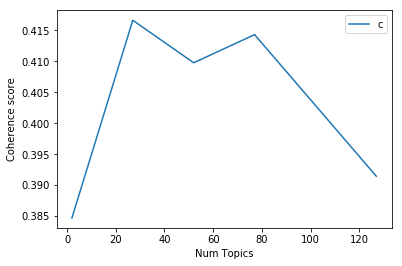

Num Topics = 2  has Coherence Value of 0.3847
Num Topics = 27  has Coherence Value of 0.4166
Num Topics = 52  has Coherence Value of 0.4098
Num Topics = 77  has Coherence Value of 0.4143
Num Topics = 102  has Coherence Value of 0.4029
Num Topics = 127  has Coherence Value of 0.3914


In [45]:
# Show graph
limit=150; start=2; step=25;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

### Depth Search

In [46]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lem_final, start=15, limit=30, step=2)

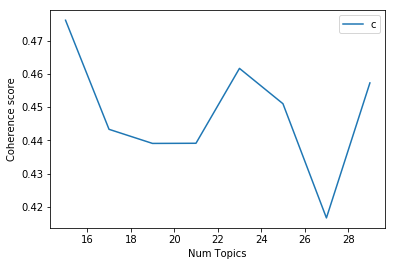

Num Topics = 15  has Coherence Value of 0.4761
Num Topics = 17  has Coherence Value of 0.4433
Num Topics = 19  has Coherence Value of 0.4391
Num Topics = 21  has Coherence Value of 0.4391
Num Topics = 23  has Coherence Value of 0.4616
Num Topics = 25  has Coherence Value of 0.451
Num Topics = 27  has Coherence Value of 0.4166
Num Topics = 29  has Coherence Value of 0.4573


In [47]:
# Show graph
limit=30; start=15; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

### Optimal Search

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lem_final, start=2, limit=12, step=2)

# Show graph
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

### Best LDA Model

In [48]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=23, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View Topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Model Perplexity and Coherence
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lem_final, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(16,
  '0.000*"revoluciaria" + 0.000*"revision_velara" + 0.000*"sunddeclap" + '
  '0.000*"serias_consecuencias" + 0.000*"savoy" + 0.000*"truristicas" + '
  '0.000*"reforestation" + 0.000*"reincidencia" + 0.000*"visitalo" + '
  '0.000*"renovare_decreto"'),
 (15,
  '0.000*"revoluciaria" + 0.000*"revision_velara" + 0.000*"sunddeclap" + '
  '0.000*"serias_consecuencias" + 0.000*"savoy" + 0.000*"truristicas" + '
  '0.000*"reforestation" + 0.000*"reincidencia" + 0.000*"visitalo" + '
  '0.000*"renovare_decreto"'),
 (12,
  '0.000*"revoluciaria" + 0.000*"revision_velara" + 0.000*"sunddeclap" + '
  '0.000*"serias_consecuencias" + 0.000*"savoy" + 0.000*"truristicas" + '
  '0.000*"reforestation" + 0.000*"reincidencia" + 0.000*"visitalo" + '
  '0.000*"renovare_decreto"'),
 (9,
  '0.004*"nuevos_seguidores" + 0.000*"ensenanza" + 0.000*"tuitutil" + '
  '0.000*"unfollowers" + 0.000*"@cocoseco" + 0.000*"@alejoropeza" + '
  '0.000*"@simarknows" + 0.000*"@retweetead0r" + 0.000*"@cheskacsk" + '
  '0.000*"

In [49]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

In [50]:
pyLDAvis.save_html(vis, '../TopicTrendsOver2016.html')